# Modèle KNN : Test de prediction de la consommation

In [12]:
#chargement
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
from pylab import rcParams

In [2]:
#lecture des données
df = pd.read_csv('clean_data/data_meteo_prod.csv', header=0, parse_dates=[0],  index_col=14,squeeze=True)

In [3]:
df['rafales_sur_une_periode']=df['rafales_sur_une_periode'].astype(float)

In [4]:
colonne_inutile =['regioncode', 'latitude', 'longitude', 'altitude',
                  'thermique_mw', 'nucleaire_mw', 'eolien_mw', 'solaire_mw',
                  'hydraulique_mw', 'pompage_mw', 'bioenergies_mw', 'ech._physiques_mw',
                  'prod_totale']
df= df.drop(colonne_inutile, axis=1)


In [5]:
df.index= pd.to_datetime(df.index)

# Knn Regressor par mois 

Nous utilisons ici les données météos pour prédire la consommation avec le modèle KNNRegressor

In [6]:
function_to_apply = {
    'rafales_sur_une_periode' : 'max',
    'variation_de_pression_en_3_heures' : 'sum',
    'precipitations_dans_les_3_dernieres_heures' : 'sum',
    'pression_station' : 'mean',
    'pression_au_niveau_mer' : 'mean',
    'direction_du_vent_moyen' : 'median', #médiane de la direction sur la journée
    'vitesse_du_vent_moyen' : 'mean',
    'humidite' : 'mean',
    'point_de_rosee' : 'mean',
    'temperature_c' : 'mean',
    'consommation_mw' : 'sum',
}
df_mois= df.resample('M').agg(function_to_apply)

In [7]:
Y = df_mois['consommation_mw']
X = df_mois.drop('consommation_mw', axis=1)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

In [9]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)   #pour pas tricher on standardise avec le fit de train
X_test_scaled = scaler.transform(X_test)

In [10]:
score_minko = []
score_man = []
score_cheb = []

for k in range(1, 41):
    knn = neighbors.KNeighborsRegressor(n_neighbors=k, metric='minkowski')
    knn.fit(X_train_scaled, y_train)
    score_minko.append(knn.score(X_test_scaled, y_test))

for k in range(1, 41):
    knn = neighbors.KNeighborsRegressor(n_neighbors=k, metric='manhattan')
    knn.fit(X_train_scaled, y_train)
    score_man.append(knn.score(X_test_scaled, y_test))
    
for k in range(1, 41):
    knn = neighbors.KNeighborsRegressor(n_neighbors=k, metric='chebyshev')
    knn.fit(X_train_scaled, y_train)
    score_cheb.append(knn.score(X_test_scaled, y_test))

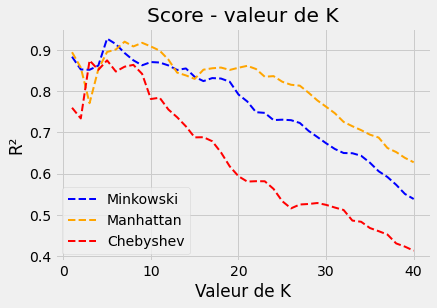

In [11]:

k = [i for i in range(1,41)]

plt.plot(k, score_minko, color='blue', linestyle='dashed', lw=2, label='Minkowski')
plt.plot(k, score_man, color='orange', linestyle='dashed', lw=2, label='Manhattan')
plt.plot(k, score_cheb, color='red', linestyle='dashed', lw=2, label='Chebyshev')
plt.title('Score - valeur de K')  
plt.xlabel('Valeur de K')  
plt.ylabel('R²') 
plt.legend();

**Il semblerait que le meilleur score soit avec le model Manhattan pour k= 5 ou 6: nous dépassons les 0.9**, confirmons et essayons de faire également varier le paramètre weights : 

In [12]:
from sklearn import model_selection
reg1 = KNeighborsRegressor()
reg1.fit(X_train_scaled, y_train)
param={"n_neighbors":list(range(1,41)),
       "weights": ["uniform", "distance"],
       "metric" :['manhattan', 'chebyshev','minkowski']}
#entrainement
grid_reg1 = model_selection.GridSearchCV(estimator=reg1, param_grid=param, cv=3)
grid_reg1.fit(X_train_scaled,y_train)
#meilleur résultat 
print("Les meilleurs paramètres pour le KNN Regressor sont :", grid_reg1.best_params_)

Les meilleurs paramètres pour le KNN Regressor sont : {'metric': 'manhattan', 'n_neighbors': 6, 'weights': 'distance'}


In [13]:
reg1 = neighbors.KNeighborsRegressor(n_neighbors=6, weights='distance', metric='manhattan')
reg1.fit(X_train_scaled, y_train)

#évaluation et prédiction
y_pred = reg1.predict(X_test_scaled)
print("Le score obtenu avec ces paramètres est", round(reg1.score(X_test_scaled, y_test)*100,2),'%')

Le score obtenu avec ces paramètres est 91.02 %


### Prediction effectuée par notre modèle - Par mois : 

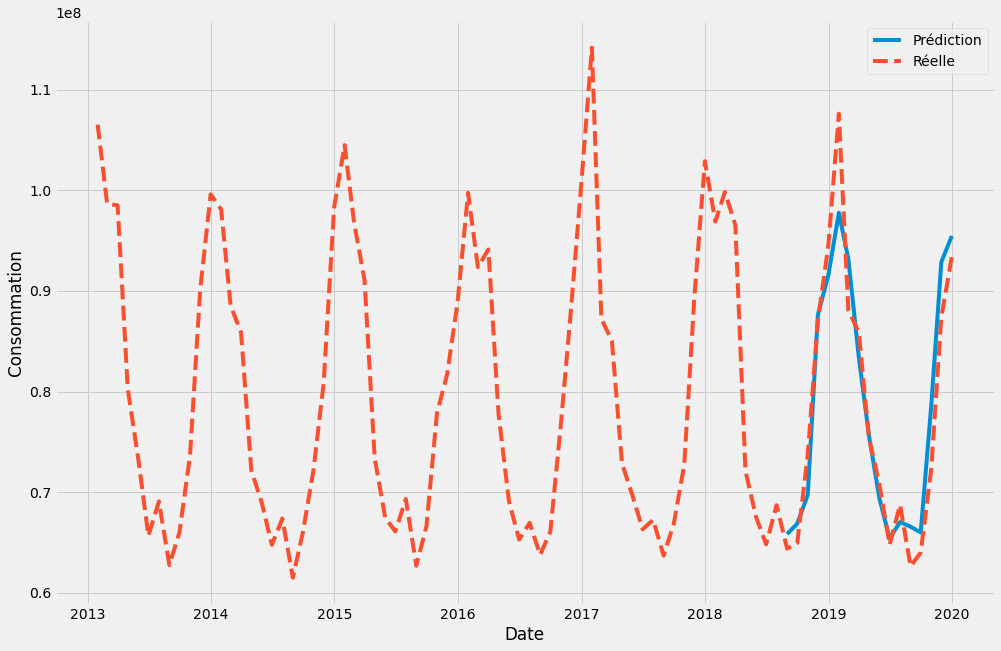

In [14]:
plt.figure(figsize=(15,10))
plt.plot(y_test.index, y_pred, label='Prédiction')
plt.plot(Y, label='Réelle', linestyle='dashed')

plt.xlabel('Date')
plt.ylabel('Consommation')
plt.legend()
plt.show();


# Knn Regressor par jour 

Nous utilisons ici les données météos pour prédire la consommation avec le modèle KNNRegressor par jour. 

**Nous nous limiterons à l'année 2018 - 2019 pour cette partie.** 

In [15]:
function_to_apply = {
    'rafales_sur_une_periode' : 'max',
    'variation_de_pression_en_3_heures' : 'sum',
    'precipitations_dans_les_3_dernieres_heures' : 'sum',
    'pression_station' : 'mean',
    'pression_au_niveau_mer' : 'mean',
    'direction_du_vent_moyen' : 'median', #médiane de la direction sur la journée
    'vitesse_du_vent_moyen' : 'mean',
    'humidite' : 'mean',
    'point_de_rosee' : 'mean',
    'temperature_c' : 'mean',
    'consommation_mw' : 'sum',
}
df_day = df.resample('D').agg(function_to_apply)
df_day = df_day.loc['2018':]

In [16]:
Y = df_day['consommation_mw']
X = df_day.drop('consommation_mw', axis=1)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

In [18]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)   #pour pas tricher on standardise avec le fit de train
X_test_scaled = scaler.transform(X_test)

In [19]:
score_minko = []
score_man = []
score_cheb = []

for k in range(1, 41):
    knn = neighbors.KNeighborsRegressor(n_neighbors=k, metric='minkowski')
    knn.fit(X_train_scaled, y_train)
    score_minko.append(knn.score(X_test_scaled, y_test))

for k in range(1, 41):
    knn = neighbors.KNeighborsRegressor(n_neighbors=k, metric='manhattan')
    knn.fit(X_train_scaled, y_train)
    score_man.append(knn.score(X_test_scaled, y_test))
    
for k in range(1, 41):
    knn = neighbors.KNeighborsRegressor(n_neighbors=k, metric='chebyshev')
    knn.fit(X_train_scaled, y_train)
    score_cheb.append(knn.score(X_test_scaled, y_test))

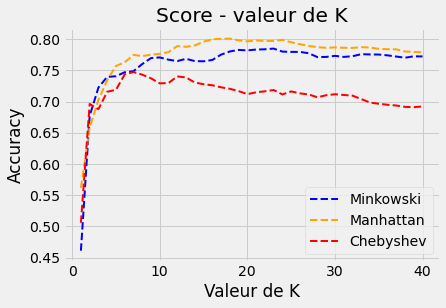

In [20]:
k = [i for i in range(1,41)]

plt.plot(k, score_minko, color='blue', linestyle='dashed', lw=2, label='Minkowski')
plt.plot(k, score_man, color='orange', linestyle='dashed', lw=2, label='Manhattan')
plt.plot(k, score_cheb, color='red', linestyle='dashed', lw=2, label='Chebyshev')
plt.title('Score - valeur de K')  
plt.xlabel('Valeur de K')  
plt.ylabel('Accuracy') 
plt.legend();

**Il semblerait que le meilleur score soit avec le model Manhattan pour k= 15 ou 16: nous touchons les 0.8**, confirmons et essayons de faire également varier le paramètre weights :

In [21]:
reg1 = KNeighborsRegressor()
reg1.fit(X_train_scaled, y_train)
param={"n_neighbors":list(range(1,41)),
       "weights": ["uniform", "distance"],
       "metric" :['manhattan', 'chebyshev','minkowski']}
#entrainement
grid_reg1 = model_selection.GridSearchCV(estimator=reg1, param_grid=param, cv=3)
grid_reg1.fit(X_train_scaled,y_train)
#meilleur résultat 
print("Les meilleurs paramètres pour le KNN Regressor sont :", grid_reg1.best_params_)

Les meilleurs paramètres pour le KNN Regressor sont : {'metric': 'manhattan', 'n_neighbors': 12, 'weights': 'distance'}


In [22]:
reg1 = neighbors.KNeighborsRegressor(n_neighbors=12, weights='distance', metric='manhattan')
reg1.fit(X_train_scaled, y_train)

#évaluation et prédiction
y_pred = reg1.predict(X_test_scaled)
print("Le score obtenu avec ces paramètres est", round(reg1.score(X_test_scaled, y_test)*100,2),'%')

Le score obtenu avec ces paramètres est 79.07 %


### Prédiction Effectuée par notre modèle - Par jour : 

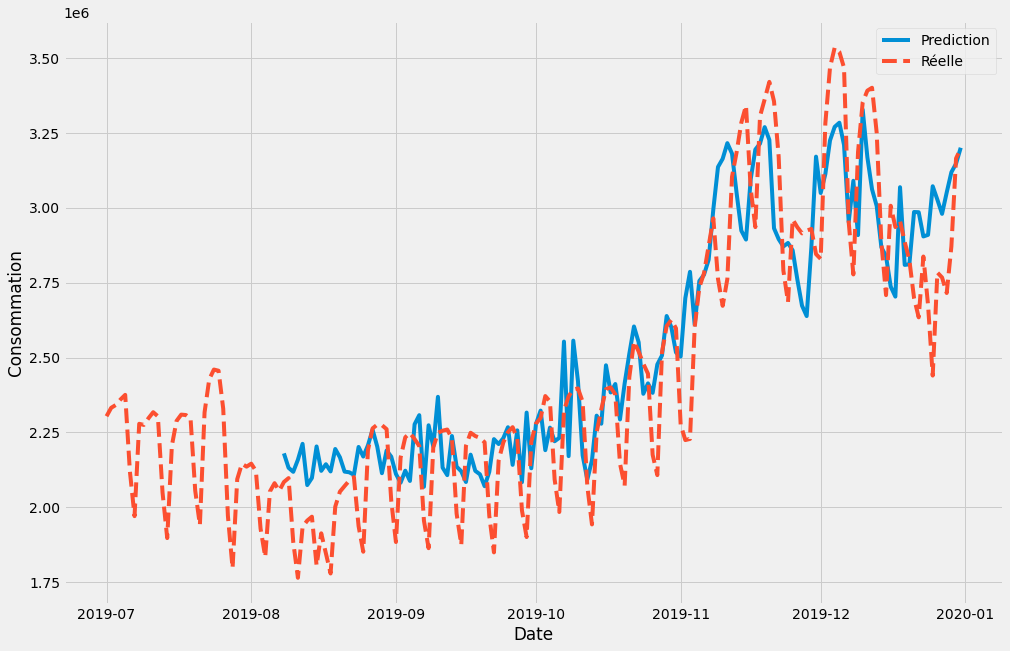

In [23]:
plt.figure(figsize=(15,10))
plt.plot(y_test.index, y_pred, label='Prediction')
plt.plot(Y['2019-07-01':], label='Réelle', linestyle='dashed')

plt.xlabel('Date')
plt.ylabel('Consommation')
plt.legend()
plt.show();

Pour la prédiction à la journée, notre modèle, proche du réel a quand même de **grande difficulté à capter les effets de saisonnalité de la consommation électrique.** 
D'où la nécessité de continuer de chercher d'estimer la consommation avec d'autres modèles.

# Par 3 heures

Granularité : 3h

Nous nous limiterons au 30 derniers jours

In [3]:
FILEPATH = 'clean_data//ener_conso_full.csv'
FILEPATH2 = 'clean_data/clean_data_meteo_3h.csv'

conso = pd.read_csv(FILEPATH, parse_dates=[0], index_col=0, squeeze=True)
meteo = pd.read_csv(FILEPATH2)
conso = conso.resample('3H').sum()
to_drop = ['regioncode','latitude', 'longitude', 'altitude',]

meteo = meteo.drop(to_drop, axis=1)
meteo['date'] = pd.to_datetime(meteo['date'])
meteo = meteo.set_index('date')
meteo = meteo['2019-12-01' : '2019-12-31']
conso = conso['2019-12-01' : '2019-12-31']

X_train, X_test, y_train, y_test = train_test_split(meteo, conso, test_size=0.2, shuffle=False)

In [4]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)   #pour pas tricher on standardise avec le fit de train
X_test_scaled = scaler.transform(X_test)

In [5]:
score_minko = []
score_man = []
score_cheb = []

for k in range(1, 41):
    knn = neighbors.KNeighborsRegressor(n_neighbors=k, metric='minkowski')
    knn.fit(X_train_scaled, y_train)
    score_minko.append(knn.score(X_test_scaled, y_test))

for k in range(1, 41):
    knn = neighbors.KNeighborsRegressor(n_neighbors=k, metric='manhattan')
    knn.fit(X_train_scaled, y_train)
    score_man.append(knn.score(X_test_scaled, y_test))
    
for k in range(1, 41):
    knn = neighbors.KNeighborsRegressor(n_neighbors=k, metric='chebyshev')
    knn.fit(X_train_scaled, y_train)
    score_cheb.append(knn.score(X_test_scaled, y_test))

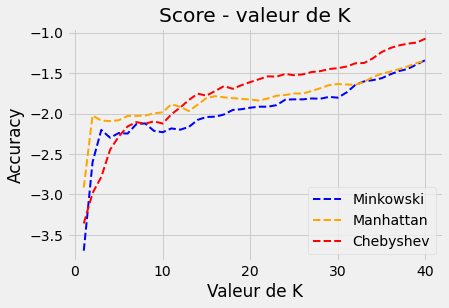

In [6]:
k = [i for i in range(1,41)]

plt.plot(k, score_minko, color='blue', linestyle='dashed', lw=2, label='Minkowski')
plt.plot(k, score_man, color='orange', linestyle='dashed', lw=2, label='Manhattan')
plt.plot(k, score_cheb, color='red', linestyle='dashed', lw=2, label='Chebyshev')
plt.title('Score - valeur de K')  
plt.xlabel('Valeur de K')  
plt.ylabel('Accuracy') 
plt.legend();

In [13]:
reg1 = KNeighborsRegressor()
reg1.fit(X_train_scaled, y_train)
param={"n_neighbors":list(range(1,41)),
       "weights": ["uniform", "distance"],
       "metric" :['manhattan', 'chebyshev','minkowski']}
#entrainement
grid_reg1 = model_selection.GridSearchCV(estimator=reg1, param_grid=param, cv=3)
grid_reg1.fit(X_train_scaled,y_train)
#meilleur résultat 
print("Les meilleurs paramètres pour le KNN Regressor sont :", grid_reg1.best_params_)

Les meilleurs paramètres pour le KNN Regressor sont : {'metric': 'minkowski', 'n_neighbors': 18, 'weights': 'uniform'}


In [19]:
reg1 = neighbors.KNeighborsRegressor(n_neighbors=18, weights='uniform', metric='minkowski')
reg1.fit(X_train_scaled, y_train)

#évaluation et prédiction
y_pred = reg1.predict(X_test_scaled)
print("Le score obtenu avec ces paramètres est", round(reg1.score(X_test_scaled, y_test)*100,2),'%')

Le score obtenu avec ces paramètres est -195.46 %


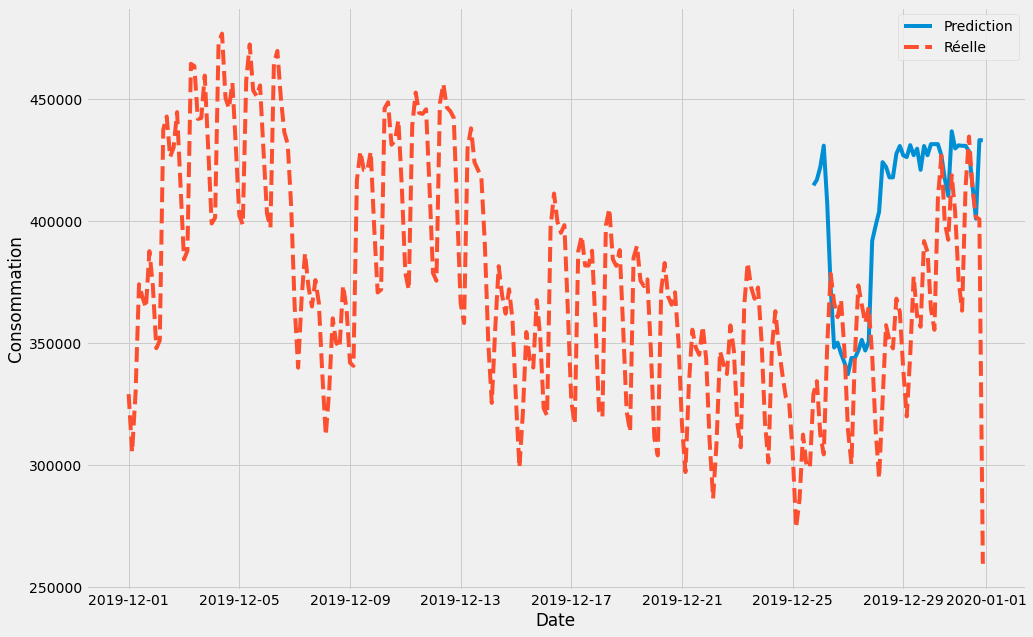

In [20]:
plt.figure(figsize=(15,10))
plt.plot(y_test.index, y_pred, label='Prediction')
plt.plot(conso['2019-12-01':], label='Réelle', linestyle='dashed')

plt.xlabel('Date')
plt.ylabel('Consommation')
plt.legend()
plt.show();